<a href="https://colab.research.google.com/github/teoalcdor/trabajo_iae/blob/main/ss_models.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Segmentación Semántica

Para la tarea de segmentación semántica vamos a utilizar el modelo U-Net. Construímos el modelo a partir de una *backbone* pre-entrenada de VGG16 cuyos pesos dejamos congelados y aplicamos *transfer learning*.

## Librerías

In [1]:
!pip install torchinfo

In [2]:
import cv2
from glob import glob
from google.colab import drive
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision import transforms
from torchvision.models import vgg16_bn, VGG16_BN_Weights
import tqdm
import copy

## Dispositivo

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


## Funciones Auxiliares

In [4]:
def unet_loss(preds, targets):
    """
    Pérdida de entropía cruzada y accuracy de U-Net para un batch
    """
    loss = nn.CrossEntropyLoss()(preds, targets)
    accuracy = (torch.max(preds, 1)[1] == targets).float().mean()
    return loss, accuracy

def train_batch(model, data, optimizer, criterion):
    """
    Entrena el modelo en un batch.
    """

    model.train() # Modo entrenamiento

    # Obtenemos la prediccion con propagacion hacia delante (logits)
    ims, masks = data
    _masks = model(ims)

    # Obtenemos la perdida
    loss, accuracy = criterion(_masks, masks)

    # Calculamos el gradiente de la perdida con retropropagacion
    loss.backward()

    # Hacemos un paso del metodo del gradiente
    optimizer.step()

    # Vaciamos el optimizador de la informacion del gradiente
    optimizer.zero_grad()

    return loss.item(), accuracy.item() # Retornamos el numero, no un tensor

@torch.no_grad()
def validate_batch(model, data, criterion):
    """
    Calcula la pérdida del modelo en el conjunto de validación.
    """

    model.eval() # Modo inferencia

    # Obtenemos la prediccion con propagacion hacia delante (logits)
    ims, masks = data
    _masks = model(ims)

    # Obtenemos la perdida
    loss, accuracy = criterion(_masks, masks)

    return loss.item(), accuracy.item() # Retornamos el numero, no un tensor


def train_model(model, optimizer, train_dataloader, val_dataloader, criterion, epochs=10):
    """
    Entrena el modelo, implementando un mecanismo que actúa como early stopping basado en
    la accuracy en validación. Devuelve también las pérdida y accuracy encontradas en
    los conjuntos de entrenamiento y valiación durante el entrenamiento.
    """

    # Inicializamos las listas con las perdidas y accuracies
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Inicializamos el mecanismo de early stopping
    best_model = {
        "model_state_dict": None,
        "optimizer_state_dict": None,
        "epoch": None,
        "max_val_accuracy": -1
    }

    for epoch in range(epochs):

        # Regristramos el momento de comienzo de la epoch
        year, month, day, h, m, s = map(lambda x : x.rjust(2, "0"),
                                          time.strftime("%y %m %d %H %M %S")
                                          .split())
        time_stamp = f"{day}/{month}/{year} {h}:{m}:{s}"
        start = time.time()
        print("=" * 80)
        print(f"Epoch: {epoch + 1} - Started: {time_stamp}")

        # Inicializamos las listas con las perdidas y accuracies de la epoch
        train_epoch_loss, train_epoch_accuracy = [], []
        val_epoch_loss, val_epoch_accuracy = [], []

        # Entrenamos el modelo con minibatch
        _n = len(train_dataloader)
        for _, inputs in tqdm.tqdm(enumerate(train_dataloader), total=_n, desc="- Training"):
            loss, accuracy = train_batch(model, inputs, optimizer, criterion)
            train_epoch_loss.append(loss)
            train_epoch_accuracy.append(accuracy)

        # Calculamos la perdida y la accuracy sobre el conjunto de validacion
        _n = len(val_dataloader)
        for _, inputs in tqdm.tqdm(enumerate(val_dataloader), total=_n, desc="- Validation"):
            loss, accuracy = validate_batch(model, inputs, criterion)
            val_epoch_loss.append(loss)
            val_epoch_accuracy.append(accuracy)

        # Actualizamos las perdidas y accuracies
        train_losses.append(np.mean(train_epoch_loss))
        train_accuracies.append(np.mean(train_epoch_accuracy))
        val_losses.append(np.mean(val_epoch_loss))
        val_accuracies.append(np.mean(val_epoch_accuracy))

        # Ponemos en marcha el mecanismo de early stopping
        if val_accuracies[-1] > best_model["max_val_accuracy"]:
            best_model["max_val_accuracy"] = val_accuracies[-1]
            best_model["model_state_dict"] = copy.deepcopy(model.state_dict())
            best_model["optimizer_state_dict"] = copy.deepcopy(optimizer.state_dict())
            best_model["epoch"] = epoch + 1

        # Regristramos el momento de comienzo de la epoch
        end = time.time()
        year, month, day, h, m, s = map(lambda x : x.rjust(2, "0"),
                                        time.strftime("%y %m %d %H %M %S")
                                        .split())
        time_stamp = f"{day}/{month}/{year} {h}:{m}:{s}"

        print(f"Epoch: {epoch + 1} - Ended: {time_stamp} - Duration: {round(end - start, 2)}s")
        print()

        # Imprimimos estadisticas de la epoch para un mejor seguimiento
        print(f"Training Loss: {train_losses[-1]} - Validation Loss: {val_losses[-1]}")
        print(f"Training Accuracy: {train_accuracies[-1]} - Validation Accuracy: {val_accuracies[-1]}")
        print("=" * 80)
        print()

    return train_losses, train_accuracies, val_losses, val_accuracies, best_model


def plot_training_results(train_losses, val_losses,
                          train_accuracies, val_accuracies, title):
    """
    Representa la pérdida y accuracy del modelo en el entrenamiento sobre
    los conjuntos de entrenamiento y validación.
    """

    # Diccionario con las perdidas
    losses_results = pd.DataFrame(
        {f"Entrenamiento": train_losses,
         f"Validación": val_losses})

    # Diccionario con las accuracies
    accuracies_results = pd.DataFrame(
        {f"Entrenamiento": train_accuracies,
         f"Validación": val_accuracies})

    with sns.axes_style("whitegrid"):
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        # Grafica de las perdidas
        losses_results_plot = sns.lineplot(data=losses_results, ax = axs[0])
        axs[0].set_ylabel("Pérdida", fontsize=17)
        axs[0].set_xlabel("Epochs", fontsize=17)
        axs[0].set_xticks([0, 4, 9, 14, 19, 24])
        axs[0].set_xticklabels([1, 5, 10, 15, 20, 25], fontsize=12)
        axs[0].tick_params(axis='y', labelsize=12)

        # Grafica de las accuracies
        accuracies_results_plot = sns.lineplot(data=accuracies_results, ax = axs[1])
        axs[1].set_xticks([0, 4, 9, 14, 19, 24])
        axs[1].set_xticklabels([1, 5, 10, 15, 20, 25], fontsize=12)
        axs[1].set_ylabel("Accuracy", fontsize=17)
        axs[1].set_xlabel("Epochs", fontsize=17)
        axs[1].tick_params(axis='y', labelsize=12)

        fig.suptitle(title, fontsize=20)
        plt.tight_layout()
        plt.show()


def decode_pred_mask(pred_mask):
    """
    Convierte el una prediccion en una máscara (de un solo canal)
    """
    decoded_mask = torch.max(pred_mask[0], 0)[1].int()
    return decoded_mask

def create_confusion_matrix_segmentation(true_masks, predicted_masks,
                                         label_encoder,
                                         title="Confusion Matrix"):
    """
    Representa y devuelve la matriz de confusión de un modelo de segmentacion.
    """

    # Calculamos la matriz de confusion como suma de las matrices de
    # confusion de cada imagen
    num_labels = len(label_encoder.classes_)
    cf_matrix = np.zeros((num_labels, num_labels))


    for true_mask, predicted_mask in zip(true_masks, predicted_masks):
        cf_matrix += confusion_matrix(
            true_mask.flatten(),
            predicted_mask.flatten(),
            labels=label_encoder.transform(label_encoder.classes_)
        )


    # Calculamos la matriz con los porcentajes
    cf_matrix_percentage = cf_matrix / cf_matrix.sum(axis=1).reshape(-1, 1) # Convertimos el vector en un array (n, 1)

    # Convertimos la matriz a DataFrame por comididad (para nombres de fila y
    # columna)
    df_cf_matrix_percentage = pd.DataFrame(cf_matrix_percentage)
    df_cf_matrix_percentage.index = label_encoder.classes_
    df_cf_matrix_percentage.columns = label_encoder.classes_

    # Formateamos los valores absolutos de cada celdilla y porcentajes
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix_percentage.flatten()]

    # A partir de los valores formateados hacemos las etiquetas
    cf_labels = np.asarray([f"{v1}" for v1 in group_percentages]).reshape(
        len(label_encoder.classes_), len(label_encoder.classes_))

    # Representamos la matriz de confusion
    sns.set_context("paper")
    fig, ax = plt.subplots(figsize=(8, 8))
    cf_plot = sns.heatmap(df_cf_matrix_percentage,
                annot=cf_labels,
                cmap="Blues", fmt="", linewidth=1, linecolor = "white",
                annot_kws={"size": 11}, ax = ax, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Predicción", fontsize=18)
    ax.set_ylabel("Verdad Subyacente", fontsize=18)
    plt.tight_layout()

    plt.show()

    return df_cf_matrix_percentage, cf_plot

@torch.no_grad()
def measure_fps_unet(model, dataset, dataloader):
    """
    Estima los FPS a los que detecta U-Net. Se tiene el cuenta el post-procesamiento.
    """

    model.eval() # Modo evaluacion
    n = len(dataset)

    # Cronometramos cuanto tardamos en detectar y procesar las detecciones de todas
    # las imagenes
    torch.cuda.synchronize()
    start_time = time.time()

    for images, _ in dataloader:
        pred_masks = model(images)
        for pred_mask in pred_masks:
            _ = decode_pred_mask(pred_mask[None])

    torch.cuda.synchronize()
    total_time = time.time() - start_time

    # Calculamos los FPS
    fps = n / total_time
    print(f"FPS: {fps:.2f}")

    return fps


def predict_unet(image, model):
    """
    Realiza una prediccion con un modelo U-Net.
    """

    model.eval() # Modo Inferencia
    image = STANDARD_TRANSFORM(image) # Transforma la imagen
    pred_mask = model(image[None].float().to(DEVICE)) # Predice
    decoded_pred_mask = decode_pred_mask(pred_mask) # Decodifica la prediccion

    return decoded_pred_mask.to("cpu").numpy()

## Datos

Montamos nuestra cuenta de Google Drive:

In [5]:
drive.mount("/content/drive/")

Mounted at /content/drive/


Descomprimimos el archivo:

In [6]:
zip_path = "/content/drive/MyDrive/trabajo_iae/datasets/ss_dataset_clean.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Leemos las etiquetas e instanciamos un LabelEnconder por comodidad:

In [10]:
labels = pd.read_csv("/content/ss_dataset_clean/train/img_02177.csv")

# Si no estamos en colab
# labels = pd.read_csv("datasets/ss_dataset/train/img_02177.csv")

label_encoder = LabelEncoder()
label_encoder.classes_ = labels[" Class"].values
label_encoder.inverse_transform(range(9))

array([' background', ' RU_airforce', ' RU_army', ' RU_marines',
       ' RU_navy', ' US_airforce', ' US_army', ' US_marines', ' US_navy'],
      dtype=object)

Definimos la transformación mínima para poder introducir las imágenes en el modelo:

In [11]:
STANDARD_TRANSFORM = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Creamos la clase del *dataset* de esta tarea:

In [12]:
class SemanticSegmentationDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.images = glob(f"{folder_path}/*.jpg")
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, ix):

        image = cv2.imread(self.images[ix])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_path = self.images[ix][:-4] + "_mask.png"
        mask = cv2.imread(mask_path)
        mask = mask[:, :, 0]
        return image, mask

    def choose(self): return self[np.random.randint(len(self))]

    def collate_fn(self, batch):
        images, masks = list(zip(*batch))

        if self.transform:
            images = [self.transform(image)[None] for image in images]


        images = torch.cat(images, dim=0).float().to(DEVICE)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(DEVICE)
        return images, masks

Instanciamos los *datasets* y los *dataloaders*

In [13]:
train_dataset = SemanticSegmentationDataset(
    folder_path="/content/ss_dataset_clean/train/", # "datasets/ss_dataset_clean/train/"
    transform=STANDARD_TRANSFORM
)
train_dataloader = DataLoader(train_dataset, batch_size=4,
                              collate_fn=train_dataset.collate_fn,
                              shuffle=True)

val_dataset = SemanticSegmentationDataset(
    folder_path="/content/ss_dataset_clean/val/", # "datasets/ss_dataset_clean/train/val/"
    transform=STANDARD_TRANSFORM
)
val_dataloader = DataLoader(val_dataset, batch_size=4,
                            collate_fn=val_dataset.collate_fn)

test_dataset = SemanticSegmentationDataset(
    folder_path="/content/ss_dataset_clean/test/", # "datasets/ss_dataset_clean/train/test/"
    transform=STANDARD_TRANSFORM
)
test_dataloader = DataLoader(test_dataset, batch_size=4,
                             collate_fn=test_dataset.collate_fn)

## Modelo

In [14]:
# Convolucion "hacia abajo"
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# Convolucion "hacia arriba"
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

# Clase de U-Net
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=9):
        super().__init__()

        # Backbone pre-entrenada a la que congelamos los pesos
        self.encoder = vgg16_bn(weights=VGG16_BN_Weights.DEFAULT).features

        for params in self.encoder.parameters():
            params.requires_grad = False

        # Bajada
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        # Suelo
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        # Subida
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Bajada
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        # Suelo
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        # Subida
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

Instanciamos el modelo y le echamos un vistazo:

In [ ]:
model = UNet().to(DEVICE)
summary(model, input_size=(1, 3, 640, 640))

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 232MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 9, 640, 640]          --
├─Sequential: 1-1                        [1, 64, 640, 640]         --
│    └─Conv2d: 2-1                       [1, 64, 640, 640]         (1,792)
│    └─BatchNorm2d: 2-2                  [1, 64, 640, 640]         (128)
│    └─ReLU: 2-3                         [1, 64, 640, 640]         --
│    └─Conv2d: 2-4                       [1, 64, 640, 640]         (36,928)
│    └─BatchNorm2d: 2-5                  [1, 64, 640, 640]         (128)
│    └─ReLU: 2-6                         [1, 64, 640, 640]         --
├─Sequential: 1-2                        [1, 128, 320, 320]        --
│    └─MaxPool2d: 2-7                    [1, 64, 320, 320]         --
│    └─Conv2d: 2-8                       [1, 128, 320, 320]        (73,856)
│    └─BatchNorm2d: 2-9                  [1, 128, 320, 320]        (256)
│    └─ReLU: 2-10                        [1, 128, 320, 320]

Entrenamos el modelo con la pérdida de entropía cruzada binaria:

In [ ]:
criterion = unet_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
train_losses, train_accuracies, val_losses, val_accuracies, best_model =\
train_model(
    model, optimizer, train_dataloader, val_dataloader, criterion, epochs=1
)

Epoch: 1 - Started: 25/05/25 21:51:11


- Validation: 100%|██████████| 55/55 [00:10<00:00,  5.12it/s]


Epoch: 1 - Ended: 25/05/25 21:54:22 - Duration: 190.95s

Training Loss: 1.042959974547432 - Validation Loss: 0.8623455611142246
Training Accuracy: 0.6706273764679113 - Validation Accuracy: 0.7132782670584592



In [ ]:
torch.save({
    "epoch": 25,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": train_losses[-1],
    "train_losses": train_losses,
    "train_accuracies": train_accuracies,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "best_model": best_model
}, "/content/drive/MyDrive/trabajo_iae/modelos/unet.pth")

## Resultados

Cargamos el checkpoint:

In [15]:
model = UNet(9).to(DEVICE)
checkpoint = torch.load("/content/drive/MyDrive/trabajo_iae/modelos/unet.pth", weights_only=False) # "modelos/unet.pth"
model.load_state_dict(checkpoint["best_model"]["model_state_dict"])

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 236MB/s]


<All keys matched successfully>

Representamos la evolución de la pérdida y de la *accuracy* a lo largo del entrenamiento:

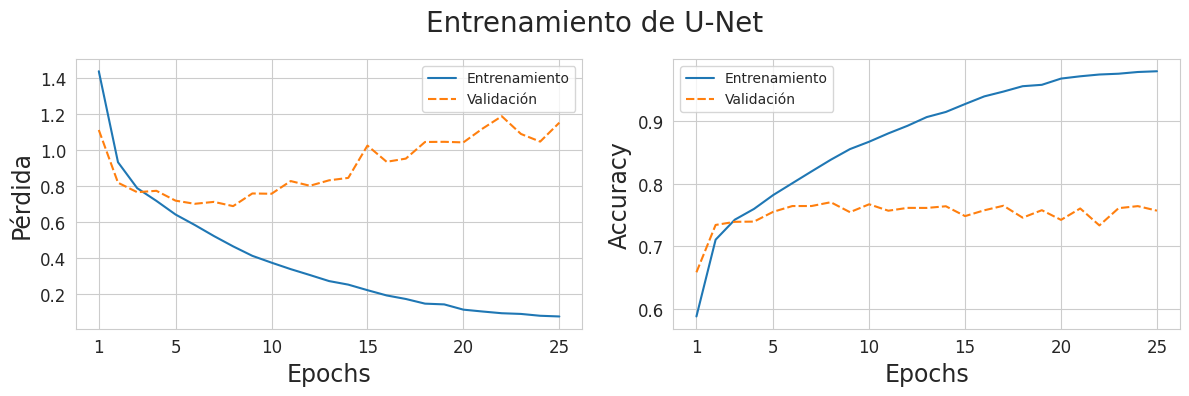

In [ ]:
plot_training_results(
    checkpoint["train_losses"],
    checkpoint["val_losses"],
    checkpoint["train_accuracies"],
    checkpoint["val_accuracies"],
    "Entrenamiento de U-Net"
)

Medimos los FPS del mejor modelo encontrado:

In [ ]:
_ = measure_fps_unet(model, val_dataset, val_dataloader)

FPS: 10.95


Representamos la matriz de confusión del mejor modelo encontrado:

In [16]:
true_masks = []
predicted_masks = []

for image, mask in val_dataset:
    true_masks.append(mask)
    predicted_masks.append(predict_unet(image, model))

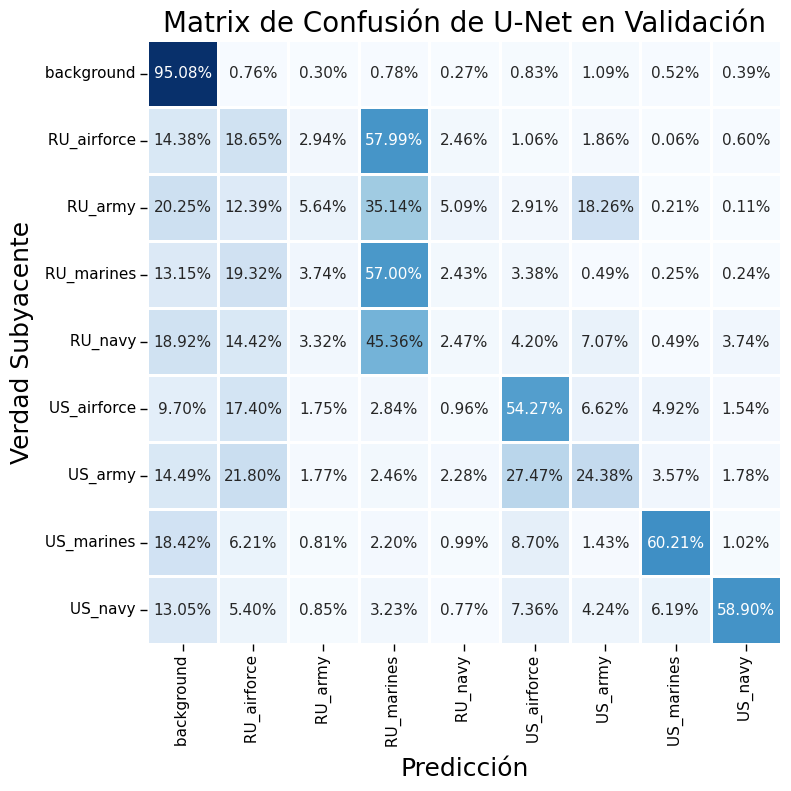

In [17]:
_, _ = create_confusion_matrix_segmentation(true_masks, predicted_masks,
                                      label_encoder,
                                      title="Matrix de Confusión de U-Net en Validación")